<a href="https://colab.research.google.com/github/Chaser2143/Ch3/blob/main/Mancala_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
"""REQUIRED INSTALLATIONS"""
! pip3 install gymnasium
! pip3 install torch

In [36]:
"""REQUIRED IMPORTS"""
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

from gymnasium import logger as gymlogger
from gymnasium import spaces
gymlogger.min_level = 40 # Error only

In [101]:
### Code Mancala Myself
import random
from enum import Enum

class GAMEMODE(Enum):
  RANDOM = 0
  SMART = 1
  TRAINED = 2

PLAYER1_SCORE_INDEX = 6
PLAYER2_SCORE_INDEX = 13

def init_board():
  """Return a new, reset board"""
  return [4,4,4,4,4,4, 0, 4,4,4,4,4,4, 0]

def get_eligible_moves(board, isPlayer1Turn):
  """Return an array of pit integers for valid moves"""
  move_set = []
  if isPlayer1Turn:
    for i in range(0,6):
      if board[i] != 0:
        move_set.append(i)
  else:
    for i in range(7,13):
      if board[i] != 0:
        move_set.append(i)
  return move_set

def make_random_move(board):
  """Make a random move for the opposite team"""
  moves = get_eligible_moves(board, False)
  return make_move(board, random.choice(moves), False)

def _get_random_move(board):
  """Get random move for P1"""
  moves = get_eligible_moves(board, True)
  return random.choice(moves)

#Faciliate AI to autonomously play as player 1
def _get_static_action_trained_dqn_first_player(network, state):
  """Select action from trained dqn network

    Chooses the best move 70% of the time
    Chooses a random move 30%

    Plays as PLAYER 1

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)

    Returns:
        action (int): chosen action [0, action_size)

    Notes:
      Mimics first player always
  """
  epsilon = 0.7

  #Valid Moves
  moves = get_eligible_moves(state, True)
  invalid_moves = [0,1,2,3,4,5]
  for move in moves:
    invalid_moves.remove(move)

    state_tensor = torch.tensor(state).float().to('cuda').detach()
    q_vals = network(state_tensor).detach()

  #Try masking instead
  for i_move in invalid_moves:
    q_vals[i_move] = -1*float(inf)

  max_index = torch.argmax(q_vals, dim=0).item()
  max_value = q_vals[max_index]

  if np.random.rand() < epsilon:
      return max_index
  else:
      # Exclude the highest Q value for the probabilistic selection
      non_max_indices = [i for i in range(len(q_vals)) if ((i != max_index) and (q_vals[i] != -1*float(inf)))]

      non_max_values = q_vals[non_max_indices]

      if not non_max_indices: #No other valid moves, take best move
        return max_index

      # Scale probabilities based on the size of non-max Q values
      probabilities = non_max_values / non_max_values.sum()

      # Choose a non-highest Q value based on these probabilities
      selected_index = random.choices(non_max_indices, weights=probabilities, k=1)[0]
      return selected_index

#Faciliate AI to autonomously play as player 2
def _get_static_action_trained_dqn_second_player(network, state):
  """Select action based on pre-trained dqn network
  Chooses moves from [7-12] as an adversary to the game

  The network has been trained to choose actions from the 1st player perspective [0-5]
  This function transforms the board for player 2 to look like it is player 1
  The network passed in then makes a decision from this perspective and returns an action
  We then transform the action back into player 2 action space

  This allows the player 1 network to play as player 2

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)

    Returns:
        action (int): chosen action [0, action_size)
  """
  board_rotation = {
      0:7,
      1:8,
      2:9,
      3:10,
      4:11,
      5:12,
      6:13,
      7:0,
      8:1,
      9:2,
      10:3,
      11:4,
      12:5,
      13:6,
  }
  transformed_board = init_board() #Empty board
  for key in board_rotation.keys():
    transformed_board[board_rotation[key]] = state[key]

  action = _get_static_action_trained_dqn_first_player(network, transformed_board)
  return board_rotation[action] #Transform to 7-12 range

def play_RL_move(board, pit_index, game_mode=GAMEMODE.RANDOM, trained_net=None):
  """
  Plays RL move then random move in sequence

  board: (array) the board
  pit_index: (int) Player 1's action
  gameMode: (GAMEMODE Enum) representing what kind of AI player to play against for player 2
  done: (bool) Is the game over

  Returns board, done
  """

  #PLAYER 1 MOVE
  board, extra_turn = make_move(board, pit_index, True) #Play RL Move
  #Check win
  if is_win(board):
    board = process_win(board)
    return board, True

  if extra_turn: #Handle giving the RL agent a second turn
    return board, False

  #Play Other move
  extra_turn = True
  while extra_turn:
    extra_turn = False

    if game_mode == GAMEMODE.RANDOM:
      board, extra_turn = make_random_move(board)
    elif game_mode == GAMEMODE.SMART:
      board, extra_turn = make_smart_move(board)
    elif game_mode == GAMEMODE.TRAINED:
      board, extra_turn = make_trained_move(board, trained_net)
    else:
      raise Exception("No valid gamemode selected! See GAMEMODE enum")

    #Check win
    if is_win(board):
      board = process_win(board)
      return board, True

  #Game not over, return board
  return board, False

def make_trained_move(board, trained_net):
  """
  Make a move based on a previously trained DQN model

  Plays as PLAYER 2
  """

  action = _get_static_action_trained_dqn_second_player(trained_net, board)
  return make_move(board, action, False)

def make_smart_move(board):
  """
  Make a smart move for the opposite team

  Smart move:
  Tries to get free turns first
  Then selects random valid move

  Plays as PLAYER 2
  """
  moves = get_eligible_moves(board, False)
  action = random.choice(moves)

  #Calculation for getting free moves
  distance_to_pit = 6
  for i in range(7,13):
    if board[i] == 6:
      action = i
      break
    distance_to_pit -= 1

  return make_move(board, action, False)

def make_move(board, pit_index:int, isPlayer1Turn:bool):
  """
  Given a board and a pit number, make a given move

  DOES NOT DO MOVE VALIDATION

  Return Board (array), ExtraTurn (boolean)
  """
  stones = board[pit_index]
  board[pit_index] = 0

  extra_turn = False

  while stones:
    pit_index += 1

    # Skip opponent's store
    if isPlayer1Turn and pit_index%14 == PLAYER2_SCORE_INDEX:
      pit_index += 1
    elif not isPlayer1Turn and pit_index%14 == PLAYER1_SCORE_INDEX:
      pit_index += 1

    board[pit_index % 14] += 1
    stones -= 1

    if stones == 0:
      #Last seed lands in your store, take extra turn
      if isPlayer1Turn and pit_index%14 == PLAYER1_SCORE_INDEX:
        extra_turn = True
      elif not isPlayer1Turn and pit_index%14 == PLAYER2_SCORE_INDEX:
        extra_turn = True

      #Last seed lands in empty dish, steal other player's stones in corresponding dish
      elif board[pit_index % 14] == 1: #The last stone lands in an empty dish
        if (isPlayer1Turn and 0<=pit_index % 14<=5) or (not isPlayer1Turn and 7<=pit_index % 14<=12):
          # Process the steal
          board = empty_capture_helper(board, pit_index % 14, isPlayer1Turn)


  return board, extra_turn

def empty_capture_helper(board, pit_index, isPlayer1Turn):
  """
  Moves stone into bank, plus opponents stones in corresponding dish

  returns board (array)
  """
  dish_map = {
      0:12,
      1:11,
      2:10,
      3:9,
      4:8,
      5:7,
      7:5,
      8:4,
      9:3,
      10:2,
      11:1,
      12:0,
  }
  score_index = 0
  if isPlayer1Turn:
    score_index = PLAYER1_SCORE_INDEX
  else:
    score_index = PLAYER2_SCORE_INDEX

  board[score_index] += 1
  board[pit_index] = 0

  opposing_dish_index = dish_map[pit_index]
  board[score_index] += board[opposing_dish_index]
  board[opposing_dish_index] = 0

  return board

def is_win(board):
  """
  Both teams need eligible moves for the game to continue

  If one team doesn't have moves, game is won
  """
  if not get_eligible_moves(board, True):
    return True
  if not get_eligible_moves(board, False):
    return True
  return False

def process_win(board):
  """
  If one team is out of stones, add all the stones to the correct pit

  return board
  """
  for i in range(0,6):
      board[PLAYER1_SCORE_INDEX] += board[i]
      board[i] = 0
  for i in range(7,13):
      board[PLAYER2_SCORE_INDEX] += board[i]
      board[i] = 0
  return board

def get_score(board):
  """Returns the score as a tuple of Player1 Score, Player 2 Score"""
  return board[PLAYER1_SCORE_INDEX], board[PLAYER2_SCORE_INDEX]

def print_board(board):
  """Prints the board from Player 1's perspective"""

  away_view = []
  for i in range(12,6,-1):
    away_view.append(board[i])

  print(away_view)
  print(f"{board[13]}_________________{board[6]}")
  print(board[0:6])
  print()

In [38]:
"""Mancala Gymnasium Environment"""

class MancalaEnv(gym.Env):
  # No metadata

  def __init__(self):
      super(MancalaEnv, self).__init__()
      self.action_space = spaces.Discrete(6) # We have a discrete variable that can take on 6 values (0-5)

      self.observation_space = spaces.Box(low=0, high=48, shape=(14,), dtype=np.int32)

  def reset(self, seed=None, options=None):
      """
      Resets the environment to an initial internal state,
      returning an initial observation and info.

      self.state -> list
      """
      super().reset(seed=seed) # Do not change this line.

      self.state = init_board()
      self.reward = 0

      return self.state, {}

  def step(self, action, game_mode=GAMEMODE.RANDOM, adversary_network=None):
    """
    Makes a step

    action: (int) action in range [0-5] represent player 1's mancala pits
    adversary_network: (QNetwork) used for making player 2's move if selected

    Returns:
    - observation: list (state after step)
    - reward: int (reward for this step)
    - terminated: boolean (whether the simulation has ended or not)
    - truncated: boolean (max number of simulation steps)
    - info: dict
    """
    self.state, done = play_RL_move(self.state, action, game_mode, adversary_network)

    #Add rewards for each point gained (1 point)
    step_reward = self.state[6] - self.reward
    self.reward += step_reward

    #Add rewards for winning the game (10 points)
    if done:
      if self.state[6] > self.state[13]:
        step_reward += 10

    return self.state, step_reward, done, False, {}

  def close(self):
    """
    Release an resources owned by environment resources
    """
    pass

DQN

In [40]:
from math import inf
def get_action_dqn(network, state, epsilon, epsilon_decay):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action
        epsilon_decay (float): amount by which to decay epsilon

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon

    Notes:
      Actions are sampled according to an  ϵ−greedy  policy to help with exploration of the state space.
      Every time an action is sampled, the agent chooses a random action with  ϵ  probability.
      Otherwise, the agent selects the action with the highest Q-value for a state.  ϵ  decays over time according to  ϵ←ϵ∗epsilon_decay .
  """
  #Random or not
  random_choice = random.random() < epsilon
  #Decay E
  epsilon *= epsilon_decay

  #Valid Moves
  moves = get_eligible_moves(state, True)
  invalid_moves = [0,1,2,3,4,5]
  for move in moves:
    invalid_moves.remove(move)

  #Random choice
  if random_choice:
    action = random.choice(moves)
  #Best choice
  else:
    state_tensor = torch.tensor(state).float().to('cuda')
    q_vals = network(state_tensor)

    #Try masking instead
    for i_move in invalid_moves:
      q_vals[i_move] = -1*float(inf)
    action = torch.argmax(q_vals, dim=0).item()
  return action, epsilon


def prepare_batch(memory, batch_size):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): (state, action, next_state, reward, done) tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
  """
  state_size = 14
  state = torch.zeros([batch_size, state_size], dtype=torch.float32, device='cuda')
  action = torch.zeros([batch_size], dtype=torch.long, device='cuda')
  next_state = torch.zeros([batch_size, state_size], dtype=torch.float32, device='cuda')
  reward = torch.zeros([batch_size], dtype=torch.float32, device='cuda')
  done = torch.zeros([batch_size], dtype=torch.float32, device='cuda')
  for i in range(batch_size):
    random_batch_int = random.randint(0,len(memory)-1)
    state[i] = torch.tensor(memory[random_batch_int][0], dtype=torch.float32, device='cuda')
    action[i] = memory[random_batch_int][1]
    next_state[i] = torch.tensor(memory[random_batch_int][2], dtype=torch.float32, device='cuda')
    reward[i] = torch.tensor(memory[random_batch_int][3], dtype=torch.float32, device='cuda')
    done[i] = torch.tensor(memory[random_batch_int][4], dtype=torch.float32, device='cuda')
  return state,action,next_state,reward,done


def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update

    Notes :
      The loss for a batch of size N is given below.

      Loss=1/N∑(Q(s,a)−(r+γmaxa′∼AQ^(s′,a′)(1−d)))2

      Loss is calculated and used to update the Q-Network.
      The target network  Q^  begins as a copy of the Q network but is not updated by the optimizer.
      Every  target_update  steps, the target network is updated with the parameters of the Q-Network.
      This process is a type of bootstrapping.

  """
  state_batch = batch[0]
  action_batch = batch[1]
  next_state_batch = batch[2]
  reward_batch = batch[3]
  done_batch = batch[4]
  batch_size = len(state_batch)

  q_s_a = q_network(state_batch)
  q_for_a_taken = q_s_a[torch.arange(0,batch_size), action_batch]

  t_s_a = torch.max(target_network(next_state_batch), dim=1)[0]

  q_comp = reward_batch + (gamma*t_s_a*(1-done_batch))

  #Update network
  optim.zero_grad()
  criterion = nn.MSELoss()
  loss = criterion(q_for_a_taken, q_comp)
  loss.backward()
  optim.step()


  if global_step % target_update == 0: #Update target network
    target_network.load_state_dict(q_network.state_dict())

In [41]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))

  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

In [9]:
def dqn_main():
  # Hyper parameters
  lr = 1e-3
  epochs = 100
  start_training = 1000
  gamma = 0.99
  batch_size = 32
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2

  # Init environment
  state_size = 14
  action_size = 6
  env = MancalaEnv()

  # Init networks
  q_network = QNetwork(state_size, action_size).cuda()
  q_network.load_state_dict(torch.load('40kDQN_vs_30kTargetNetwork_state_dict.pt'))
  q_network.eval()
  q_network.train() #Set it so we will update this model

  target_network = QNetwork(state_size, action_size).cuda()
  target_network.load_state_dict(q_network.state_dict())
  target_network.eval() #This model is only ever updated with the state dict from q_net, so it doesn't need the gradients updated

  # #Static adversary network
  # adversary_network = QNetwork(state_size, action_size).cuda()
  # adversary_network.load_state_dict(torch.load('DQN_VS_Smart_AI_20k_state_dict.pt'))
  # adversary_network.eval() #Static model, doesn't need trained

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  # Init replay buffer
  memory = []

  # Begin main loop
  results_dqn = []
  winratio = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)

  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)

    # Reset environment
    state, _ = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward > -10:  # End after 200 steps
      # Select e-greedy action
      action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay)

      # Take step
      next_state, reward, terminated, truncated, _ = env.step(action, GAMEMODE.TRAINED, target_network)
      # Note : We are currently training against the target_network. Gamemode can be changed, or use a static QNetwork
      done = terminated or truncated

      if done:
        if next_state[6] > next_state[13]:
          winratio.append(1)
        else:
          winratio.append(0)

      # Store step in replay buffer
      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        batch = prepare_batch(memory, batch_size)

        # Train
        learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
    env.close()
    # Print results at end of episode
    if epoch%10==0:
      results_dqn.append(cum_reward)

    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

  return results_dqn, winratio, q_network

results_dqn, winloss, q_network = dqn_main()

<ipython-input-9-4fdc6611decf>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_network.load_state_dict(torch.load('40kDQN_vs_30kTargetNetwork_state_dict.pt'))


In [ ]:
# Save weights to pickle file
torch.save(q_network.state_dict(), 'state_dict_model.pt')

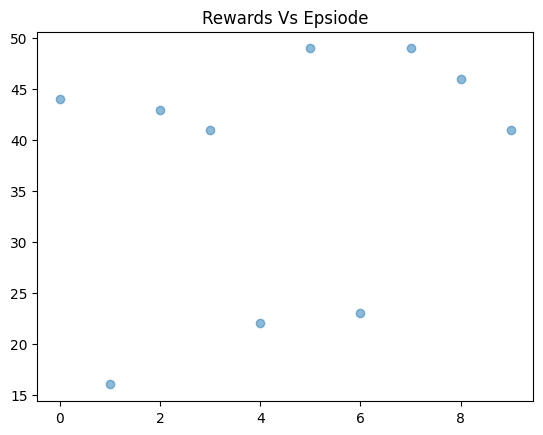

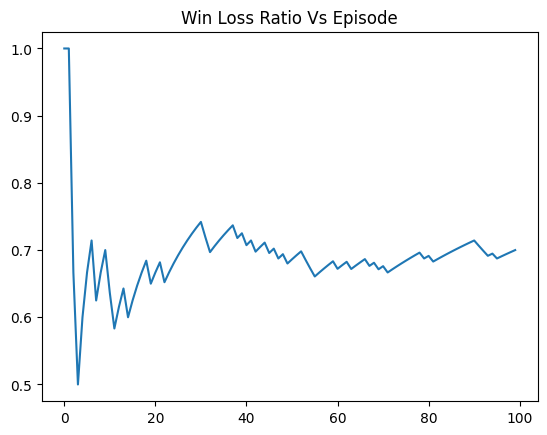

In [10]:
# Graph Results after last run on dqn_main()

import statistics
plt.plot(results_dqn, 'o', alpha=0.5) #Change the kind of plot here
plt.title("Rewards Vs Epsiode")
plt.show()


#Compute Win Loss Ratio as we train
rolling_sum = [0 for i in range(len(winloss))]
rolling_sum[0] = winloss[0]
for i in range(1, len(winloss)):
  rolling_sum[i] = rolling_sum[i-1] + winloss[i]

for i in range(0, len(rolling_sum)):
  rolling_sum[i] = rolling_sum[i] / (i+1)

plt.plot(rolling_sum)
plt.title("Win Loss Ratio Vs Episode")
plt.show()

In [78]:
#Functions to faciliate human vs RL agent gameplay
def trained_play_RL_move_vs_human(board, pit_index):
  """
  Plays RL move then human move in sequence

  Returns board (array), done (bool)
  """

  board, extra_turn = make_move(board, pit_index, True) #Play RL Move
  print("Board after RL Move")
  print_board(board)
  #Check win
  if is_win(board):
    board = process_win(board)
    print("Game Over")
    print_board(board)
    return board, True

  if extra_turn: #Handle giving the RL agent a second turn
    print("Extra Turn for RL Agent")
    return board, False


  #Play Other move
  extra_turn = True
  while extra_turn:
    extra_turn = False
    print("Make your move [7-12]:")
    move = int(input())
    board, extra_turn = make_move(board, move, False)
    print("Board after Human Move")
    print_board(board)
    #Check win
    if is_win(board):
      board = process_win(board)
      print("Game Over")
      print_board(board)
      return board, True

  #Else, return board
  return board, False

In [105]:
### Play the model myself

state_size = 14
action_size = 6

#Static adversary network
adversary_network = QNetwork(state_size, action_size).cuda()
adversary_network.load_state_dict(torch.load('DQN_VS_Smart_AI_20k_state_dict.pt'))
adversary_network.eval() #Static model, doesn't need trained

done = False
board = init_board()
while not done:
  rl_move = trained_play_RL_move_vs_human(adversary_network, board)
  board, done = trained_play_RL_move_vs_human(board, rl_move)

<ipython-input-105-292dfc1b180d>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adversary_network.load_state_dict(torch.load('DQN_VS_Smart_AI_20k_state_dict.pt'))


TypeError: 'QNetwork' object is not subscriptable

In [103]:
###Benchmarks
state_size = 14
action_size = 6

#Set up networks
network_40k = QNetwork(state_size, action_size).cuda()
network_40k.load_state_dict(torch.load('40kDQN_vs_30kTargetNetwork_state_dict.pt'))
network_40k.eval() #Static model, doesn't need trained

network_30k = QNetwork(state_size, action_size).cuda()
network_30k.load_state_dict(torch.load('30kDQN_VS_20kDQN_state_dict.pt'))
network_30k.eval() #Static model, doesn't need trained

network_20k = QNetwork(state_size, action_size).cuda()
network_20k.load_state_dict(torch.load('DQN_VS_Smart_AI_20k_state_dict.pt'))
network_20k.eval() #Static model, doesn't need trained

def benchmark(p1, p2=None):
  #Set up stats
  games_won = 0

  epochs = 1000
  loop = tqdm(total=epochs, position=0, leave=False)
  for epoch in range(epochs):
    board = init_board()

    done = False
    while not done:
      # action = _get_static_action_trained_dqn_first_player(p1, board)
      action = _get_random_move(board)
      board, done = play_RL_move(board, action, GAMEMODE.SMART, p2)

    #If game won, add
    if board[6] > board[13]:
      # print("Game Won!")
      games_won += 1
    loop.update(1)
    loop.set_description('Episodes: {} Games Won {}'.format(epoch, games_won))
  return games_won, epochs

games_won, epochs = benchmark(network_40k)
print(f"Win Rate (of {epochs} games):", games_won/epochs)

<ipython-input-103-4703a68d8abe>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network_40k.load_state_dict(torch.load('40kDQN_vs_30kTargetNetwork_state_dict.pt'))
<ipytho

Win Rate (of 1000 games): 0.417
